# Text classification with movie reviews

**The model itself is unchanged from the original tensorflow example. Jump to "Explaination" for what I added.**


This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

We'll use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.

This notebook uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow. For a more advanced text classification tutorial using `tf.keras`, see the [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/).

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import keras

import numpy as np

print(keras.__version__)

from keras import backend as K

2.2.4


Using TensorFlow backend.


## Download the IMDB dataset

In [2]:
imdb = tf.keras.datasets.imdb


(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

The argument `num_words=10000` keeps the top 10,000 most frequently occurring words in the training data. The rare words are discarded to keep the size of the data manageable.

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


The text of reviews have been converted to integers, where each integer represents a specific word in a dictionary. Here's what the first review looks like:

In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Movie reviews may be different lengths. The below code shows the number of words in the first and second reviews. Since inputs to a neural network must be the same length, we'll need to resolve this later.

In [5]:
len(train_data[0]), len(train_data[1])

(218, 189)

### Convert the integers back to words


In [6]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

Now we can use the `decode_review` function to display the text for the first review:

In [7]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [8]:
train_labels[0]

1

## Prepare the data

The reviews—the arrays of integers—must be converted to tensors before fed into the neural network. This conversion can be done a couple of ways:

* Convert the arrays into vectors of 0s and 1s indicating word occurrence, similar to a one-hot encoding. For example, the sequence  [3, 5] would become a 10,000-dimensional vector that is all zeros except for indices 3 and 5, which are ones. Then, make this the first layer in our network—a Dense layer—that can handle floating point vector data. This approach is memory intensive, though, requiring a `num_words * num_reviews` size matrix.

* Alternatively, we can pad the arrays so they all have the same length, then create an integer tensor of shape `max_length * num_reviews`. We can use an embedding layer capable of handling this shape as the first layer in our network.

In this tutorial, we will use the second approach.

Since the movie reviews must be the same length, we will use the [pad_sequences](https://keras.io/preprocessing/sequence/#pad_sequences) function to standardize the lengths:

In [9]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

## Build the model


In [10]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1))

model.summary()

W0729 09:45:46.144242  8544 deprecation_wrapper.py:119] From C:\Users\benma\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 09:45:46.179289  8544 deprecation_wrapper.py:119] From C:\Users\benma\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 09:45:46.185695  8544 deprecation_wrapper.py:119] From C:\Users\benma\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


### Loss function and optimizer


In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

W0729 09:45:46.599624  8544 deprecation_wrapper.py:119] From C:\Users\benma\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0729 09:45:46.651319  8544 deprecation_wrapper.py:119] From C:\Users\benma\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0729 09:45:46.662209  8544 deprecation.py:323] From C:\Users\benma\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Create a validation set



In [12]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Train the model


In [13]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

W0729 09:45:47.251770  8544 deprecation_wrapper.py:119] From C:\Users\benma\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 96us/step - loss: 2.0774 - acc: 0.5035 - val_loss: 1.4127 - val_acc: 0.4947
Epoch 2/40
15000/15000 [==============================] - 1s 73us/step - loss: 1.3117 - acc: 0.5035 - val_loss: 1.2588 - val_acc: 0.4947
Epoch 3/40
15000/15000 [==============================] - 1s 67us/step - loss: 1.1789 - acc: 0.5035 - val_loss: 1.1343 - val_acc: 0.4947
Epoch 4/40
15000/15000 [==============================] - 1s 75us/step - loss: 1.0620 - acc: 0.5035 - val_loss: 1.0205 - val_acc: 0.4947
Epoch 5/40
15000/15000 [==============================] - 1s 75us/step - loss: 0.9594 - acc: 0.5035 - val_loss: 0.9252 - val_acc: 0.4947
Epoch 6/40
15000/15000 [==============================] - 1s 71us/step - loss: 0.8755 - acc: 0.5035 - val_loss: 0.8488 - val_acc: 0.4947
Epoch 7/40
15000/15000 [==============================] - 1s 72us/step - loss: 0.8093 - acc: 0.5035 - val_loss: 0.7905 - val_acc

## Evaluate the model


In [14]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 33us/step
[0.39457490626335145, 0.85468]


In [15]:
predictions = model.predict(train_data)
print(train_labels[0:10])
print()
print(predictions[0:10])

[1 0 0 1 0 0 1 0 1 0]

[[ 1.3911397 ]
 [-0.04094058]
 [-0.02608004]
 [ 1.0719385 ]
 [-0.06336878]
 [ 0.5636585 ]
 [ 0.90471137]
 [-0.06632318]
 [ 1.3722389 ]
 [ 0.55248046]]


In [16]:
predictions[0]

array([1.3911397], dtype=float32)

## Create a graph of accuracy and loss over time



In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [18]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

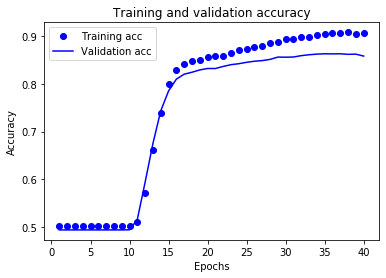

In [19]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Explanation 

In [20]:
import innvestigate

So trying with the original model threw "'NoneType' object has no attribute '_keras_shape'". Suspecting there was some issue with the model itself, I tried the same data with a simpler model.

In [21]:
#analyzer = innvestigate.create_analyzer('lrp.z', model)
#analyzer.analyze(train_data) 

**Test Model**

I simply made a model of all dense layers because I know that works with iNNvestigate. The model is horribly innaccurate, but the important thing is I can show how the problem of text classification works. 

In [22]:
test_model = keras.Sequential()
test_model.add(keras.layers.Dense(256))
test_model.add(keras.layers.Dense(256))
test_model.add(keras.layers.Dense(16, activation=tf.nn.relu))
test_model.add(keras.layers.Dense(1))


In [23]:
test_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [24]:
test_history = test_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 60us/step - loss: 8.0500 - acc: 1.3333e-04 - val_loss: 7.9103 - val_acc: 1.0000e-04
Epoch 2/40
15000/15000 [==============================] - 0s 22us/step - loss: 8.0353 - acc: 1.3333e-04 - val_loss: 8.0157 - val_acc: 1.0000e-04
Epoch 3/40
15000/15000 [==============================] - 0s 21us/step - loss: 7.9550 - acc: 0.0000e+00 - val_loss: 8.1279 - val_acc: 0.0000e+00
Epoch 4/40
15000/15000 [==============================] - 0s 20us/step - loss: 7.9779 - acc: 0.0000e+00 - val_loss: 8.1334 - val_acc: 0.0000e+00
Epoch 5/40
15000/15000 [==============================] - 0s 20us/step - loss: 7.9779 - acc: 0.0000e+00 - val_loss: 8.1287 - val_acc: 0.0000e+00
Epoch 6/40
15000/15000 [==============================] - 0s 21us/step - loss: 7.9726 - acc: 0.0000e+00 - val_loss: 8.1287 - val_acc: 0.0000e+00
Epoch 7/40
15000/15000 [==============================] - 0s 21us/step - loss: 7

In [25]:
test_analyzer = innvestigate.create_analyzer('lrp.z', test_model)

In [26]:
test_analyzer.analyze(train_data)

array([[-3.21403658e-03,  1.11330605e+00,  1.82230008e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-2.54344232e-02,  1.22961559e+01,  9.17402649e+01, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-1.16619319e-02,  8.35447431e-01,  4.28936243e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       ...,
       [-9.07554198e-03,  6.86146319e-01,  5.89920282e-01, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-1.88483242e-02,  8.47297592e+01,  6.02085815e+02, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-1.16619365e-02,  1.01447177e+00,  5.47578216e-01, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]], dtype=float32)

No errors now. Yay!

In [27]:
a = np.squeeze(test_analyzer.analyze(train_data)) #modifying analysis into array of relevance scores


In [28]:
words = decode_review(train_data[0]) #translate the words from numbers to actual words

In [29]:
words = words.split(" ") #turn string of words into a list

This function is taken right from iNNvestigate's Sentiment analysis example( https://github.com/albermax/innvestigate/blob/master/examples/notebooks/sentiment_analysis.ipynb). It takes in a list of words and an array of their relevance scores, and it creates a visualization of each word's relevance.

In [30]:
from matplotlib import cm, transforms


In [31]:
# This is a utility method visualizing the relevance scores of each word to the network's prediction. 
# one might skip understanding the function, and see its output first.
def plot_text_heatmap(words, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')

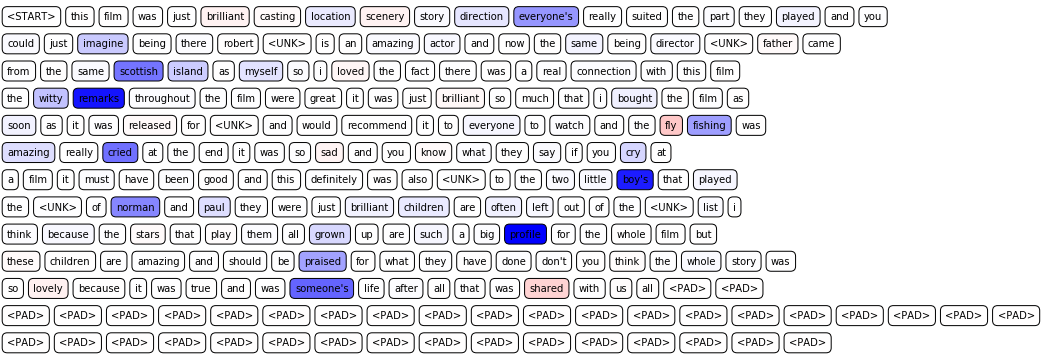

In [32]:
plot_text_heatmap(words, a[0])

The explanation is bad becuase the model is bad, but it works!